## Load The Data "Tiny Stories"

In [1]:
from datasets import load_from_disk
dataset = load_from_disk("./tinystories_local")

c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GPT-2 Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from datasets import load_from_disk
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
import os
import matplotlib.pyplot as plt

# Set environment variable to reduce memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Explanation
**Purpose**: The `PositionalEncoding` class adds positional information to token embeddings to capture the order of tokens in a sequence, as transformers lack inherent sequence awareness. It uses sinusoidal functions to generate encodings that allow the model to differentiate token positions.

In [ ]:
# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

### Explanation
**Purpose**: The `MultiHeadSelfAttention` class implements multi-head self-attention, a core mechanism in transformers that allows the model to focus on different parts of the input sequence simultaneously across multiple attention heads.

In [ ]:
# 2. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(self.d_k)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(context)
        return output

### Explanation
**Purpose**: The `FeedForward` class implements a position-wise feed-forward neural network (FFN) applied to each token in the sequence, adding non-linearity and increasing the model’s capacity to learn complex patterns.

In [ ]:
# 3. Feed-Forward Neural Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

### Explanation
**Purpose**: The `DecoderLayer` class represents a single layer of the GPT-2 decoder, combining multi-head self-attention and a feed-forward network with residual connections and layer normalization for stable training.

In [ ]:
# 4. Transformer Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

### Explanation
**Purpose**: The `GPT2` class defines the complete GPT-2 model architecture, stacking multiple decoder layers to process input tokens and generate text.

In [ ]:
# 5. GPT-2 Model
class GPT2(nn.Module):
    def __init__(self, vocab_size, d_model=768, num_layers=2, num_heads=12, d_ff=3072, max_len=256, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.decoder_layers:
            x = layer(x, mask)
        return self.output_layer(x)

    def generate(self, input_ids, max_length=50, method="greedy"):
        self.eval()
        with torch.no_grad():
            for _ in range(max_length):
                mask = torch.tril(torch.ones(input_ids.size(1), input_ids.size(1), device=device)).unsqueeze(0).unsqueeze(0)
                logits = self(input_ids, mask)[:, -1, :]
                if method == "greedy":
                    next_token = torch.argmax(logits, dim=-1, keepdim=True)
                else:
                    probs = torch.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                input_ids = torch.cat([input_ids, next_token], dim=1)
                if next_token.item() == tokenizer.eos_token_id:
                    break
        return input_ids

### Explanation
**Purpose**: The `TinyStoriesDataset` class prepares the TinyStories dataset for training by tokenizing text samples and creating input-target pairs for language modeling.

In [ ]:
# 6. Dataset Preparation
class TinyStoriesDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=256):
        self.data = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            text = self.data[idx]["text"]
            encoding = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True)
            encoding = encoding + [self.tokenizer.pad_token_id] * (self.max_length - len(encoding))
            input_ids = torch.tensor(encoding[:-1], dtype=torch.long)
            target_ids = torch.tensor(encoding[1:], dtype=torch.long)
            return input_ids, target_ids
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            encoding = [self.tokenizer.pad_token_id] * self.max_length
            input_ids = torch.tensor(encoding[:-1], dtype=torch.long)
            target_ids = torch.tensor(encoding[1:], dtype=torch.long)
            return input_ids, target_ids


**Explaination**:  
This section initializes the tokenizer for the GPT-2 model using the `GPT2Tokenizer` from the `transformers` library.  
- **Purpose**: Converts text into token IDs and vice versa, enabling the model to process input text and generate output.  
- **Details**:  
  - Loads the pre-trained GPT-2 tokenizer (`gpt2`) from Hugging Face.  
  - Sets the padding token to the end-of-sequence (`eos`) token to ensure consistent handling of padded sequences.  
- **Output**: A configured `tokenizer` object used for encoding/decoding text in the dataset and generation steps.

In [ ]:
# 7. Tokenizer
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load dataset locally and select the 'train' split
dataset = load_from_disk("./tinystories_local")
train_dataset_full = dataset['train']

# Select 10% of the dataset
subset_size = int(0.1 * len(train_dataset_full))
indices = [int(i) for i in np.random.choice(len(train_dataset_full), subset_size, replace=False)]
subset_dataset = Subset(train_dataset_full, indices)

# Split the subset into 90% train and 10% test
train_size = int(0.9 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create data loaders
train_data = TinyStoriesDataset(train_dataset, tokenizer, max_length=256)
test_data = TinyStoriesDataset(test_dataset, tokenizer, max_length=256)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)

**Description**:  
This section configures the GPT-2 model, optimizer, and loss function for training.  
- **Purpose**: Sets up the model architecture and training components to process tokenized input and learn from the dataset.  
- **Details**:  
  - **Vocabulary Size**: Uses the tokenizer’s vocabulary size (`tokenizer.vocab_size`) to define the model’s output layer.  
  - **Model**: Initializes a `GPT2` model with:  
    - `d_model=768` (embedding dimension).  
    - `num_layers=4` (transformer decoder layers).  
    - `num_heads=12` (attention heads).  
    - `d_ff=3072` (feed-forward dimension).  
    - `max_len=256` (maximum sequence length).  
    - Moves the model to the specified device (GPU or CPU).  
  - **Optimizer**: Uses `AdamW` with a learning rate of `3e-4` for parameter optimization.  
  - **Loss Function**: Uses `CrossEntropyLoss`, ignoring the padding token (`tokenizer.pad_token_id`) to avoid penalizing padding in the loss calculation.

In [ ]:
# 8. Model Configuration
vocab_size = tokenizer.vocab_size
model = GPT2(vocab_size=vocab_size, d_model=768, num_layers=2, num_heads=12, d_ff=3072, max_len=256).to(device)
# model = GPT2(vocab_size=vocab_size, d_model=512, num_layers=2, num_heads=8, d_ff=2048, max_len=256).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

### Explanation
**Purpose**: The `train_model` function trains the GPT-2 model using the provided data loader, loss function, and optimizer, incorporating gradient accumulation to manage memory usage.

In [ ]:
# 9. Training Loop with Gradient Accumulation
def train_model(model, train_loader, criterion, optimizer, epochs=5, save_path="gpt2_model.pth", accum_steps=2):
    model.train()
    total_batches = len(train_loader)
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        optimizer.zero_grad()

        for batch_idx, (input_ids, target_ids) in enumerate(train_loader):
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)
            mask = torch.tril(torch.ones(input_ids.size(1), input_ids.size(1), device=device)).unsqueeze(0).unsqueeze(0)
            outputs = model(input_ids, mask)
            loss = criterion(outputs.view(-1, vocab_size), target_ids.view(-1))
            loss = loss / accum_steps
            loss.backward()

            # Compute accuracy
            preds = torch.argmax(outputs, dim=-1)
            mask = target_ids != tokenizer.pad_token_id
            correct = (preds == target_ids).masked_select(mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()

            if (batch_idx + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accum_steps
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{total_batches}, Loss: {loss.item() * accum_steps:.4f}")

        if (batch_idx + 1) % accum_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss / total_batches
        avg_accuracy = total_correct / total_tokens if total_tokens > 0 else 0
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(avg_accuracy)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}")

        # Save model after each epoch
        epoch_save_path = f"gpt2_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), epoch_save_path)
        print(f"Model saved to {epoch_save_path}")

        # Generate text after each epoch
        prompt = "Once upon a time, in a small village"
        generated_text = generate_text(model, prompt, max_length=50, method="greedy")
        text_save_path = f"generated_text_epoch_{epoch+1}.txt"
        with open(text_save_path, "w") as f:
            f.write(generated_text)
        print(f"Generated text saved to {text_save_path}")

    # Save final model
    torch.save(model.state_dict(), save_path)
    print(f"Final model saved to {save_path}")

    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), epoch_accuracies, marker='o', color='orange')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    print("Training metrics plot saved to 'training_metrics.png'")
    # plt.show() is not used to avoid blocking

    return epoch_losses, epoch_accuracies

### Explanation
**Purpose**: The `compute_perplexity` function evaluates the model’s performance on the test set by calculating perplexity, a metric that measures how well the model predicts the next token.

In [ ]:
# 10. Evaluation: Perplexity
def compute_perplexity(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for input_ids, target_ids in test_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)
            mask = torch.tril(torch.ones(input_ids.size(1), input_ids.size(1), device=device)).unsqueeze(0).unsqueeze(0)
            outputs = model(input_ids, mask)
            loss = criterion(outputs.view(-1, vocab_size), target_ids.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    perplexity = math.exp(avg_loss)
    return perplexity

### Explanation
**Purpose**: The `generate_text` function generates text from a given prompt using the trained GPT-2 model, either greedily or by sampling.

In [ ]:
# 11. Text Generation
def generate_text(model, prompt, max_length=50, method="greedy"):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(input_ids, max_length, method)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

### Explanation
**Purpose**: The `load_model` function loads a pre-trained model from a file for evaluation or text generation.

In [ ]:
# 12. Load Model for Testing
def load_model(model, load_path="gpt2_model.pth"):
    model.load_state_dict(torch.load(load_path, map_location=device))
    model.to(device)
    print(f"Model loaded from {load_path}")
    return model

Using device: cuda


c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Total training samples: 190773
Batches per epoch: 23847
Epoch 1, Batch 0/23847, Loss: 10.9593
Epoch 1, Batch 100/23847, Loss: 5.1272
Epoch 1, Batch 200/23847, Loss: 4.2372
Epoch 1, Batch 300/23847, Loss: 4.1515
Epoch 1, Batch 400/23847, Loss: 3.8328
Epoch 1, Batch 500/23847, Loss: 3.9342
Epoch 1, Batch 600/23847, Loss: 3.6265
Epoch 1, Batch 700/23847, Loss: 3.6117
Epoch 1, Batch 800/23847, Loss: 3.9043
Epoch 1, Batch 900/23847, Loss: 3.5438
Epoch 1, Batch 1000/23847, Loss: 3.6595
Epoch 1, Batch 1100/23847, Loss: 3.8341
Epoch 1, Batch 1200/23847, Loss: 3.2842
Epoch 1, Batch 1300/23847, Loss: 3.8146
Epoch 1, Batch 1400/23847, Loss: 3.4929
Epoch 1, Batch 1500/23847, Loss: 3.2926
Epoch 1, Batch 1600/23847, Loss: 3.5424
Epoch 1, Batch 1700/23847, Loss: 3.6029
Epoch 1, Batch 1800/23847, Loss: 3.1146
Epoch 1, Batch 1900/23847, Loss: 3.5192
Epoch 1, Batch 2000/23847, Loss: 3.3561
Epoch 1, Batch 2100/23847, Loss: 3.4270
Epoch 1, Batch 2200/23847, Loss: 3.5290
Epoch 1, Batch 2300/23847, Loss: 3.

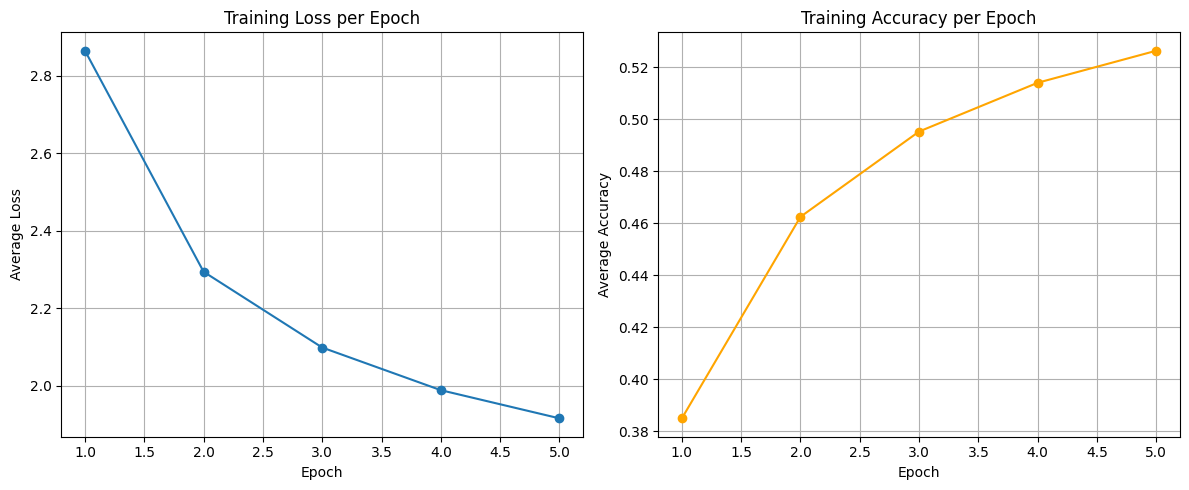

In [ ]:
# Main Execution
if __name__ == "__main__":
    print(f"Total training samples: {len(train_dataset)}")
    print(f"Batches per epoch: {len(train_loader)}")
    # Option 1: Train the model
    train_model(model, train_loader, criterion, optimizer, epochs=5, save_path="gpt2_model.pth", accum_steps=2)

    # Option 2: Load pre-trained model and test
    model = load_model(model, load_path="gpt2_model.pth")

    # Evaluate perplexity
    perplexity = compute_perplexity(model, test_loader)
    print(f"Test Perplexity: {perplexity:.2f}")

    # Generate sample text
    prompt = "Once upon a time, in a small village"
    generated_text = generate_text(model, prompt, max_length=50, method="greedy")
    print(f"Generated Text:\n{generated_text}")

    # Save generated text for report
    with open("generated_text.txt", "w") as f:
        f.write(generated_text)

## Testing

In [8]:
import torch
import torch.nn as nn
import math
from transformers import GPT2Tokenizer

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# 2. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(self.d_k)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(context)
        return output

# 3. Feed-Forward Neural Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

# 4. Transformer Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# 5. GPT-2 Model
class GPT2(nn.Module):
    def __init__(self, vocab_size, d_model=768, num_layers=2, num_heads=12, d_ff=3072, max_len=256, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.decoder_layers:
            x = layer(x, mask)
        return self.output_layer(x)

    def generate(self, input_ids, max_length=50, method="greedy"):
        self.eval()
        with torch.no_grad():
            for _ in range(max_length):
                mask = torch.tril(torch.ones(input_ids.size(1), input_ids.size(1), device=device)).unsqueeze(0).unsqueeze(0)
                logits = self(input_ids, mask)[:, -1, :]
                if method == "greedy":
                    next_token = torch.argmax(logits, dim=-1, keepdim=True)
                else:
                    probs = torch.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                input_ids = torch.cat([input_ids, next_token], dim=1)
                if next_token.item() == tokenizer.eos_token_id:
                    break
        return input_ids

# 6. Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# 7. Load Model
def load_model(model, load_path="gpt2_model.pth"):
    model.load_state_dict(torch.load(load_path, map_location=device))
    model.to(device)
    print(f"Model loaded from {load_path}")
    return model

# 8. Generate Text
def generate_text(model, prompt, max_length=50, method="greedy"):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(input_ids, max_length, method)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Main Execution
if __name__ == "__main__":
    # Initialize model
    vocab_size = tokenizer.vocab_size
    model = GPT2(vocab_size=vocab_size, d_model=768, num_layers=2, num_heads=12, d_ff=3072, max_len=256).to(device)

    # Load saved model 
    load_path = r"D:\me\College\3rd year 2nd term\Pattern\final project\gpt2_model.pth" # Put the model path here.
    model = load_model(model, load_path)

    # Test
    prompts = [
        "I have a cat",
    ]

    for prompt in prompts:
        generated_text = generate_text(model, prompt, max_length=50, method="greedy")
        print(f"\nPrompt: {prompt}")
        print(f"Generated Text: {generated_text}")

Using device: cuda
Model loaded from D:\me\College\3rd year 2nd term\Pattern\final project\gpt2_model.pth

Prompt: I have a cat
Generated Text: I have a cat. The cat named Kitty was very happy cat. Kitty loved to play with her tail and run around the house.
One day, Kitty saw a big box in the box. Kitty wanted to play with the box. She ran to open it.
